In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import HTML
# import keras_tuner as kt
from tensorflow import keras
# from kerastuner import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
import pandas as pd
import glob
import shutil
import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8227 files belonging to 7 classes.


In [6]:
class_names = dataset.class_names
class_names

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']

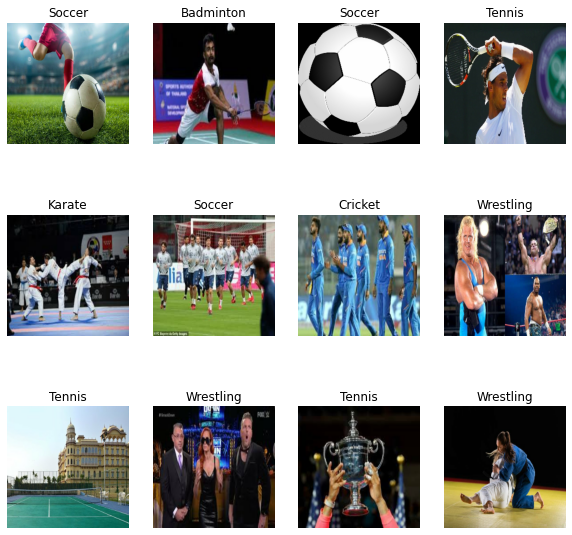

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<BarContainer object of 7 artists>

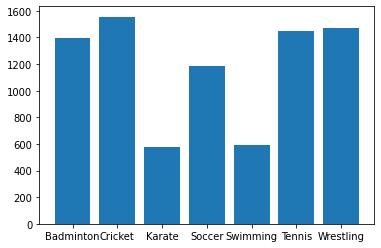

In [29]:
plt.bar(class_names,[1394,1556,578,1188,595,1445,1471])

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [66]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds),len(val_ds),len(test_ds))

206 25 27


In [67]:
#Cache shuffle and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomContrast(0.7),
   layers.experimental.preprocessing.RandomRotation(0.2),
])

In [69]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [70]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
resnet = ResNet50(input_shape=[IMAGE_SIZE,IMAGE_SIZE,3], weights='imagenet', include_top=False)

In [72]:
for layer in resnet.layers:
    layer.trainable = False

In [73]:
x = Flatten()(resnet.output)

In [74]:
prediction = Dense(n_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [75]:
# view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [76]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [77]:
# fit the model
r = model.fit(
  train_ds,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_data=val_ds,
  epochs=20,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds)
)

Epoch 1/20
206/206 [==============================] - 76s 331ms/step - loss: 9.7432 - accuracy: 0.6188 - val_loss: 4.7595 - val_accuracy: 0.7987
Epoch 2/20
206/206 [==============================] - 91s 443ms/step - loss: 8.3603 - accuracy: 0.7279 - val_loss: 6.4847 - val_accuracy: 0.8200
Epoch 3/20
206/206 [==============================] - 99s 481ms/step - loss: 7.6648 - accuracy: 0.7724 - val_loss: 5.2278 - val_accuracy: 0.8325
Epoch 4/20
206/206 [==============================] - 100s 486ms/step - loss: 6.7704 - accuracy: 0.7948 - val_loss: 7.2276 - val_accuracy: 0.8238
Epoch 5/20
206/206 [==============================] - 99s 480ms/step - loss: 6.7335 - accuracy: 0.8106 - val_loss: 9.9036 - val_accuracy: 0.7900
Epoch 6/20
206/206 [==============================] - 99s 481ms/step - loss: 6.6772 - accuracy: 0.8204 - val_loss: 5.4050 - val_accuracy: 0.8537
Epoch 7/20
206/206 [==============================] - 99s 482ms/step - loss: 5.8435 - accuracy: 0.8450 - val_loss: 6.1833 - val_a

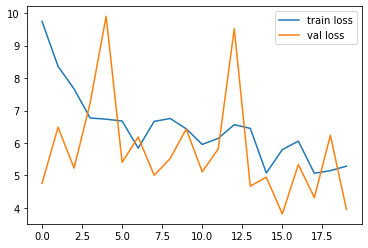

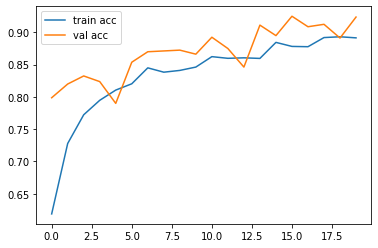

<Figure size 432x288 with 0 Axes>

In [79]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [78]:
scores = model.evaluate(test_ds)
scores

27/27 [==============================] - 11s 138ms/step - loss: 4.5665 - accuracy: 0.9213


[4.566525459289551, 0.9212962985038757]

In [84]:
import pathlib
dataset_url = "C:/Users/prath/Official/DL Datasets/Sports image classification/test"
import cv2
import os

def predict_sport(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

def load_images_from_folder(folder):
    label = []
    confi = []
    for filename in test_df['image_ID']:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
        predicted_class, confidence = predict_sport(model, img)
        if img is not None:
            label.append(predicted_class)
            confi.append(confidence)
        else:
            print("Image error")
    return label,confi

In [82]:
#For testing dataset

test_df = pd.read_csv("test.csv")

test_df.head()

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg


In [85]:
label,confi = load_images_from_folder(dataset_url)
test_df['label'] = label
test_df['confidence'] = confi
test_df.head()

,image_ID,label,confidence
0,f5e13966e7.jpg,Soccer,100.00
1,6674191b4e.jpg,Tennis,99.95
2,91b5f8b7a9.jpg,Tennis,100.00
3,393119b6d6.jpg,Wrestling,100.00
4,1ce5f81578.jpg,Tennis,100.00


In [86]:
sample_submission = test_df[['image_ID','label']]
sample_submission.to_csv("sample_submission_3.csv")